# Monte-Carlo Uncertainty

This notebook complements the [docs](https://luminovo.gitlab.io/midnite/uncertainty.html) on how to use the uncertainty part of midnite.

In [1]:
%%capture
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

## Classification Example with AlexNet

In the following, we demonstrate uncertainty measurements of an image classification example.

### Step 1: Load Pretrained model

**Note: Model must have been trained with dropout.**

In [2]:
import torchvision.models as models
from torch.nn import Softmax

alexnet = models.alexnet(pretrained=True)
alexnet.classifier.add_module("softmax", Softmax(dim=1))

### Step 2: Create MC Dropout Ensemble

 - Ensemble wraps the whole thing
 - EnsembleBegin starts the stochastic part of the model
 - EnsembleLayer wraps the stochastic part
 - We can use StochasticDropouts to obtain StochasticModule from alexnet since it uses `torch.nn` Dropout layers

In [3]:
from midnite.uncertainty import *

alexnet_ensemble = Ensemble(
    EnsembleBegin(num_passes=50),
    PredictionAndUncertainties(),
    EnsembleLayer(StochasticDropouts(alexnet)),
)

alexnet_ensemble.stochastic_eval();

### Step 3: Load Data
Since we want to compare uncertainties, we load a few different images:
 - one image (cat) in a class for which the model was trained (in-distribution example)
 - one image outside ImageNet classes (out-of-distribution example)
 - random noise

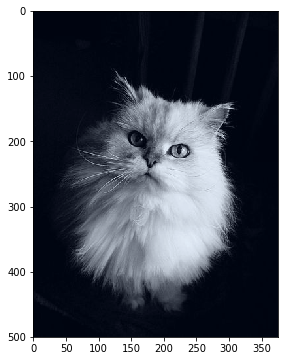

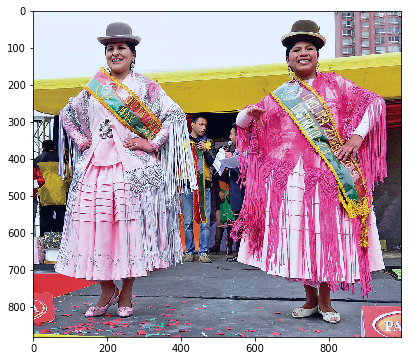

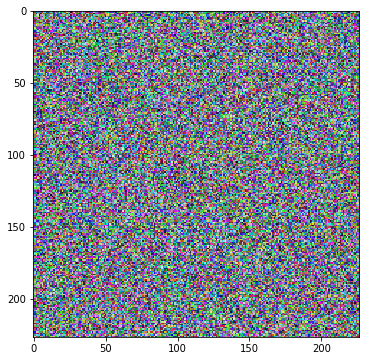

In [4]:
import data_utils
from plot_utils import show_normalized

id_example = data_utils.get_example_from_path(
    "../data/imagenet_example_283.jpg", data_utils.DataConfig.ALEX_NET)

ood_example = data_utils.get_example_from_path(
    "../data/ood_example.jpg", data_utils.DataConfig.ALEX_NET)

random_example = data_utils.get_random_example(
    data_utils.DataConfig.ALEX_NET)

show_normalized(id_example)
show_normalized(ood_example)
show_normalized(random_example)

### Step 4: Calculate Uncertainties

Correct label for in-distribution image: 283

In [5]:
import torch
import midnite
import tabletext

# Run without gradients, on cpu (use cuda:0 instead if you have a gpu available)
with torch.no_grad():
    with midnite.device("cpu"):
        id_pr = alexnet_ensemble(id_example)
        ood_pr = alexnet_ensemble(ood_example)
        rand_pr = alexnet_ensemble(random_example)
        
# Print pretty table
table = [
    ["", "in-dist.", "out-of-dist.", "random"],
    ["max prediction", id_pr[0].argmax(),
     ood_pr[0].argmax(), rand_pr[0].argmax()],
    ["max probability", f"{id_pr[0].max():.3f}",
     f"{ood_pr[0].max():.3f}", f"{rand_pr[0].max():.3f}"],
    ["pred. entropy (~total uncert.)", f"{id_pr[1].sum():.3f}",
     f"{ood_pr[1].sum():.3f}", f"{rand_pr[1].sum():.3f}"],
    ["mutual info. (~model uncert.)", f"{id_pr[2].sum():.3f}",
     f"{ood_pr[2].sum():.3f}", f"{rand_pr[2].sum():.3f}"]
]
print(tabletext.to_text(table, header=True))

100%|██████████| 50/50 [00:01<00:00, 25.11it/s]

╒════════════════════════════════╤══════════╤══════════════╤════════╕
│                                │ in-dist. │ out-of-dist. │ random │
╞════════════════════════════════╪══════════╪══════════════╪════════╡
│ max prediction                 │      283 │          614 │    735 │
├────────────────────────────────┼──────────┼──────────────┼────────┤
│ max probability                │ 0.551    │ 0.020        │ 0.149  │
├────────────────────────────────┼──────────┼──────────────┼────────┤
│ pred. entropy (~total uncert.) │ 2.781    │ 6.076        │ 4.138  │
├────────────────────────────────┼──────────┼──────────────┼────────┤
│ mutual info. (~model uncert.)  │ 0.195    │ 0.105        │ 0.223  │
└────────────────────────────────┴──────────┴──────────────┴────────┘


### Results and Interpretation

We can see that:

- the in-distribution example has low total uncertainty, but high model uncertainty
    - possible explanation: image is correctly classified, but not with very high confidence. Since the data uncertainty is not as high, most of the error is in our model.
- the out-of distribution example has much higher predictive entropy, but lower mutual information (-> model uncertainty)
    - possible explanation: since the image is not in the distribution, model uncertainty can be low (= the model parameters fit), but in total, uncertainty is high
- the random example has total uncertainty, but higher model uncertainty
    - possible explanation: the parameters can't really explain the data

## Image Segmentation (Visual) Example
Image segmentation has the nice property that we can actually see _where_ uncertainty is high, so the following is an example using a FCN32.
### Step 1: Prepare Ensemble
Similar to last example, we build an Ensemble for a pre-trained network, this time for one (in-dist) image:

In [6]:
%%capture
from pytorch_fcn.fcn32s import FCN32s

fcn = FCN32s()
fcn.load_state_dict(torch.load(FCN32s.download()));

fcn_ensemble = Ensemble(
    EnsembleBegin(num_passes=10), # Set higher if you have the computing resources
    PredictionAndUncertainties(),
    EnsembleLayer(StochasticDropouts(fcn)),
    EnsembleLayer(Softmax(dim=1)),
)

fcn_ensemble.stochastic_eval()

### Step 2: Load Data

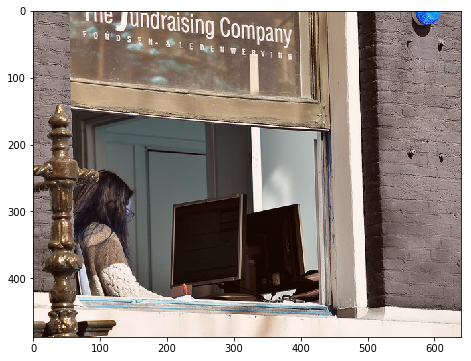

In [7]:
img = data_utils.get_example_from_path(
    "../data/fcn_example.jpg", data_utils.DataConfig.FCN32)

show_normalized(img)

### Step 3: Predict Uncertainties

100%|██████████| 10/10 [00:00<00:00, 10.01it/s]


Max prediction:


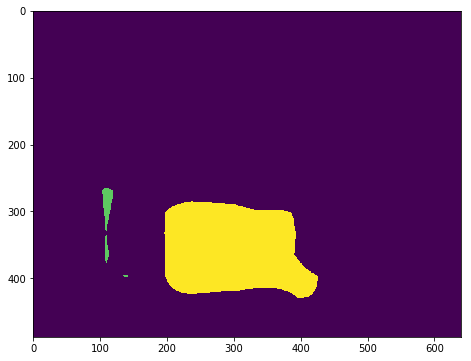

Predictive entropy (total uncertainty):


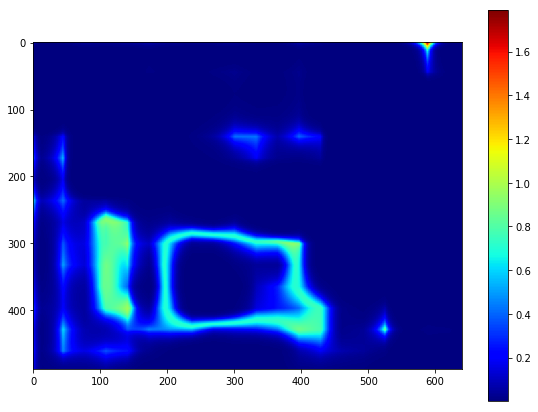

Mutual information (model uncertainty):


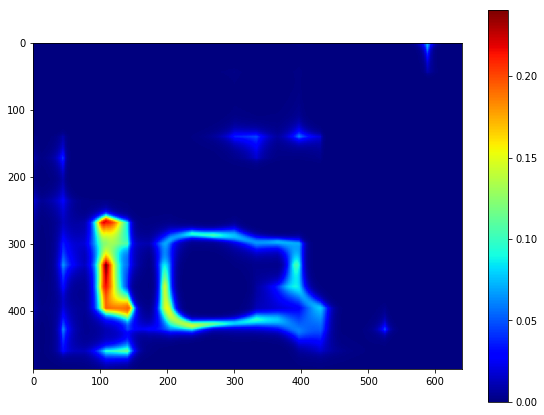

In [8]:
from plot_utils import show, show_heatmap

with torch.no_grad():
    with midnite.device("cpu"): # GPU device if available, e.g. "cuda:0"!
        pred, pred_entropy, mutual_info = fcn_ensemble(img)

print("Max prediction:")
show(pred.argmax(dim=1))

print("Predictive entropy (total uncertainty):")
show_heatmap(pred_entropy.sum(dim=1), 1.2)

print("Mutual information (model uncertainty):")
show_heatmap(mutual_info.sum(dim=1), 1.2)

### Interpretation

If we overlay the original image and the mutual information, we can see on which objects the segmentation model was unsure:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


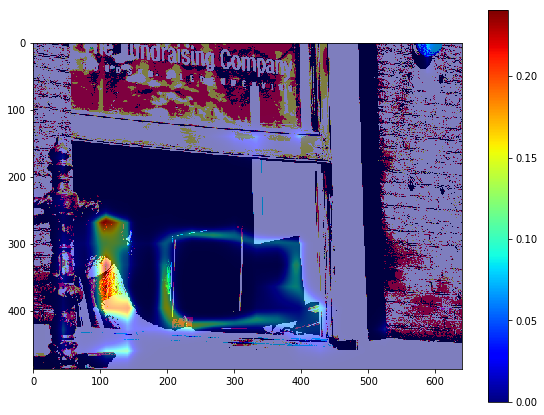

In [9]:
show_heatmap(mutual_info.sum(dim=1), 1.2, img)